# Reconstructing 2D Cosmic Dust Maps from Scattered Observations
# AM 205 Final Project
# Stephen Slater, Zizheng Xu, Kenny Chen
## This document contains the code and plots for our project. We have organized the process into individual steps.

# Basic Overview:
## First, we collect data from the SFD dataset of dust extinction measurements (taken as "ground truth" in this paper). This involves querying a specific region of the sky (see Step 1) and creating a benchmark image. Overall, collecting data requires a lot of knowledge about astronomy, but the basic point is that we acquire a large number of sample observations, and then we choose a selection of scattered observations within a specific region in order to reconstruct a dust map of that region.
## Then, we reconstruct a coarse map using the sample points, which can be then be interpolated to a smooth image. The methods we describe in the paper include (1) inverse Lanczos interpolation and (2) polynomial fitting, but we also implement and test other methods, including Chebyshev polynomial fitting, polynomial interpolation, and radial basis function approximation.
## Finally, we Lanczos interpolate the reconstructed coarse map into a smooth image from which astronomers can query.

## Along the way, we have included several results and plots used in the report, and others which we decided not to include for reasons of length, repetitive analysis, or future work.

Note that there are many dependency modules in this project.

In [1]:
# Import packages for astronomical observations and reconstruction methods
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from scipy.ndimage.filters import gaussian_filter
from numpy.polynomial.chebyshev import chebfit, chebval2d, chebvander2d
from numpy.polynomial.polynomial import polyvander2d, polyval2d

import astropy.units as units
from astropy.coordinates import SkyCoord

from dustmaps.sfd import SFDQuery
from astropy.io import fits

This document reads data from hard drive (therefore independent of the package "dustmap") to do this project. Without recollecting the data (Steps 1, 3, 4), a user requires the following datasets and modules to read in the data:
- full_700x700.fits
- xye_1m.pickle
- bucketed_data_100x100.pickle

Python modules:
- astropy.io.fits
- pickle

## Step 1a: Query SFD dustmap to get "true" extinction observations. Demo of collecting data from dustmaps module: https://dustmaps.readthedocs.io/en/latest/examples.html#plotting-the-dust-maps

## Skip to Step 1b if the user wants to load the saved data from hard drive.

In [ ]:
# Center of cloud in arcminutes (adjusted center down by 20' to avoid sparse region)
l0, b0 = (37. * 60., (-16. - 20.) * 60.)

# Define latitude and longitude of region of sky
l = np.arange(l0 - (349.5 * 2.4), l0 + (349.5 * 2.4) + 0.01, 2.4)
b = np.arange(b0 - (349.5 * 2.4), b0 + (349.5 * 2.4) + 0.01, 2.4)
lmin = l[0]
bmin = b[0]

# Ensure a 700x700 image
print (l[-1] - l[0])
print (b[-1] - b[0])
print (700 * 2.4)
assert len(l) == len(b) == 700

# Retrieve sky coordinates and then sample observations
l, b = np.meshgrid(l, b)
coords = SkyCoord(l*units.arcmin, b*units.arcmin,
                  distance=1.*units.kpc, frame='galactic')

sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coords)
A = Av_sfd

## Step 1b: Alternatively, load the data from hard drive.

In [ ]:
# Get map
A = fits.getdata('full_700x700.fits')
Av_sfd=A

## Step 2: Show the data. 

Interpolation method: nearest


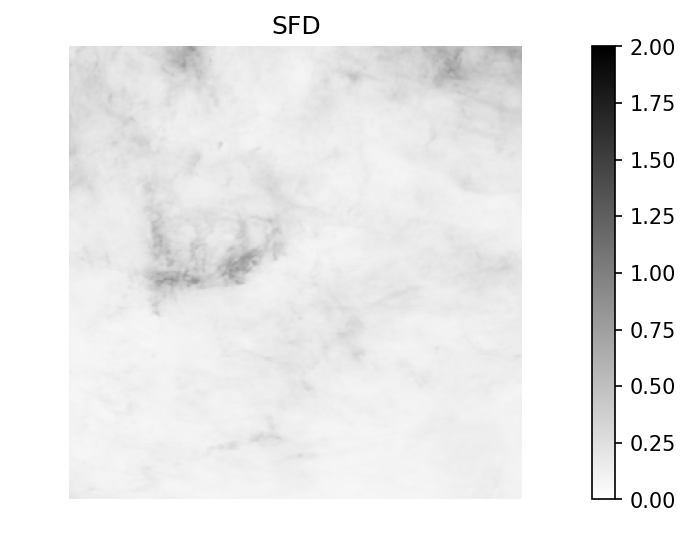

In [2]:
for interp_method in ['nearest']:
    print ("Interpolation method: {}".format(interp_method))
    fig = plt.figure(figsize=(12,4), dpi=150)
    for k,(Av,title) in enumerate([(A, 'SFD')]):
        ax = plt.gca()
        plt.imshow(
            Av[::,::-1],
            vmin=0.,
            vmax=2.,
            origin='lower',
            interpolation=interp_method,
            cmap='binary',
            aspect='equal'
        )
        ax.axis('off')
        ax.set_title(title)
        plt.colorbar()

    fig.subplots_adjust(wspace=0., hspace=0.)

This map is the "ground truth" (700x700 pixels).

## Step 3: Truncate the map to the inner (500 x 500) image

(500, 500)


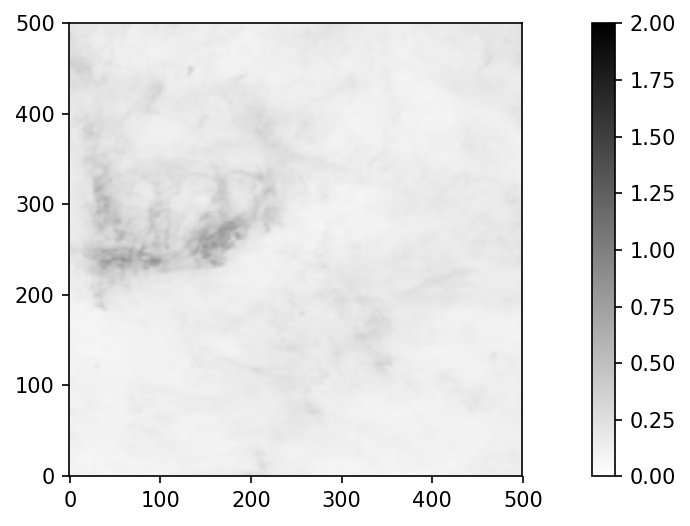

In [3]:
trimmed = Av_sfd[100:600, 100:600]
print (trimmed.shape)

fig = plt.figure(figsize=(12,4), dpi=150)
plt.imshow(
    trimmed[::,::-1],
    vmin=0.,
    vmax=2.,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
plt.colorbar()

## Step 4a: Get $\{(X, Y, E)\}_{k=1}^{NW^2}$, where $W$ is the width of the image and $N$ is the average number of observations per pixel. We show the code for generating the sample data here. Rather than sample new data each time, we can read the data from hard drive in Step 4b.

In [ ]:
'''
For every 25 pixel square (5x5), we get 100 samples
We have 700^2 pixels
Therefore, we need (100/25) * 700^2 = 2.8e5 samples
We then use the samples corresponding to the inner 500x500 image in Step 5.
'''
np.random.seed(0)
xys = np.random.uniform(low=0, high=700, size=(280000, 2), )
print (xys)
print (xys.shape)

# Query dustmap to get E values
def get_E(x, y):
    coords = SkyCoord((lmin + 2.4 * x)*units.arcmin, (bmin + 2.4*y)*units.arcmin,
                    distance=1.*units.kpc, frame='galactic')
    sfd = SFDQuery()
    Es = 2.742 * sfd(coords)
    Es = np.reshape(Es, [-1, 1])
    return Es


xs = xys[:, 0]
ys = xys[:, 1]
Es = get_E(xs, ys)

print ("Es:\n{}".format(Es))
print (Es.shape)
print (xys.shape)
data = np.append(xys, Es, axis=-1)

print ("\ndata:\n{}".format(data))
print (data.shape)

## Step 4b: Alternatively, load the data

In [ ]:
# Load data
with open("xye_1m.pickle","rb") as f:
    example_1 = pickle.load(f)
data=example_1

## Step 5: Scatter plot the data.
This data is in the file "xye_1m.pickle", shown in a scatter plot below.

We have on average 100 datapoints per "big" pixel, so altogether 100 \* 100 \* 100 data points, with $x,y \in [99.5,599.5] \times [99.5,599.5]$. This is because we choose the $500^2$ pixel centers at $\{(100, 100), (100, 101), \ldots, (500, 500) \}.

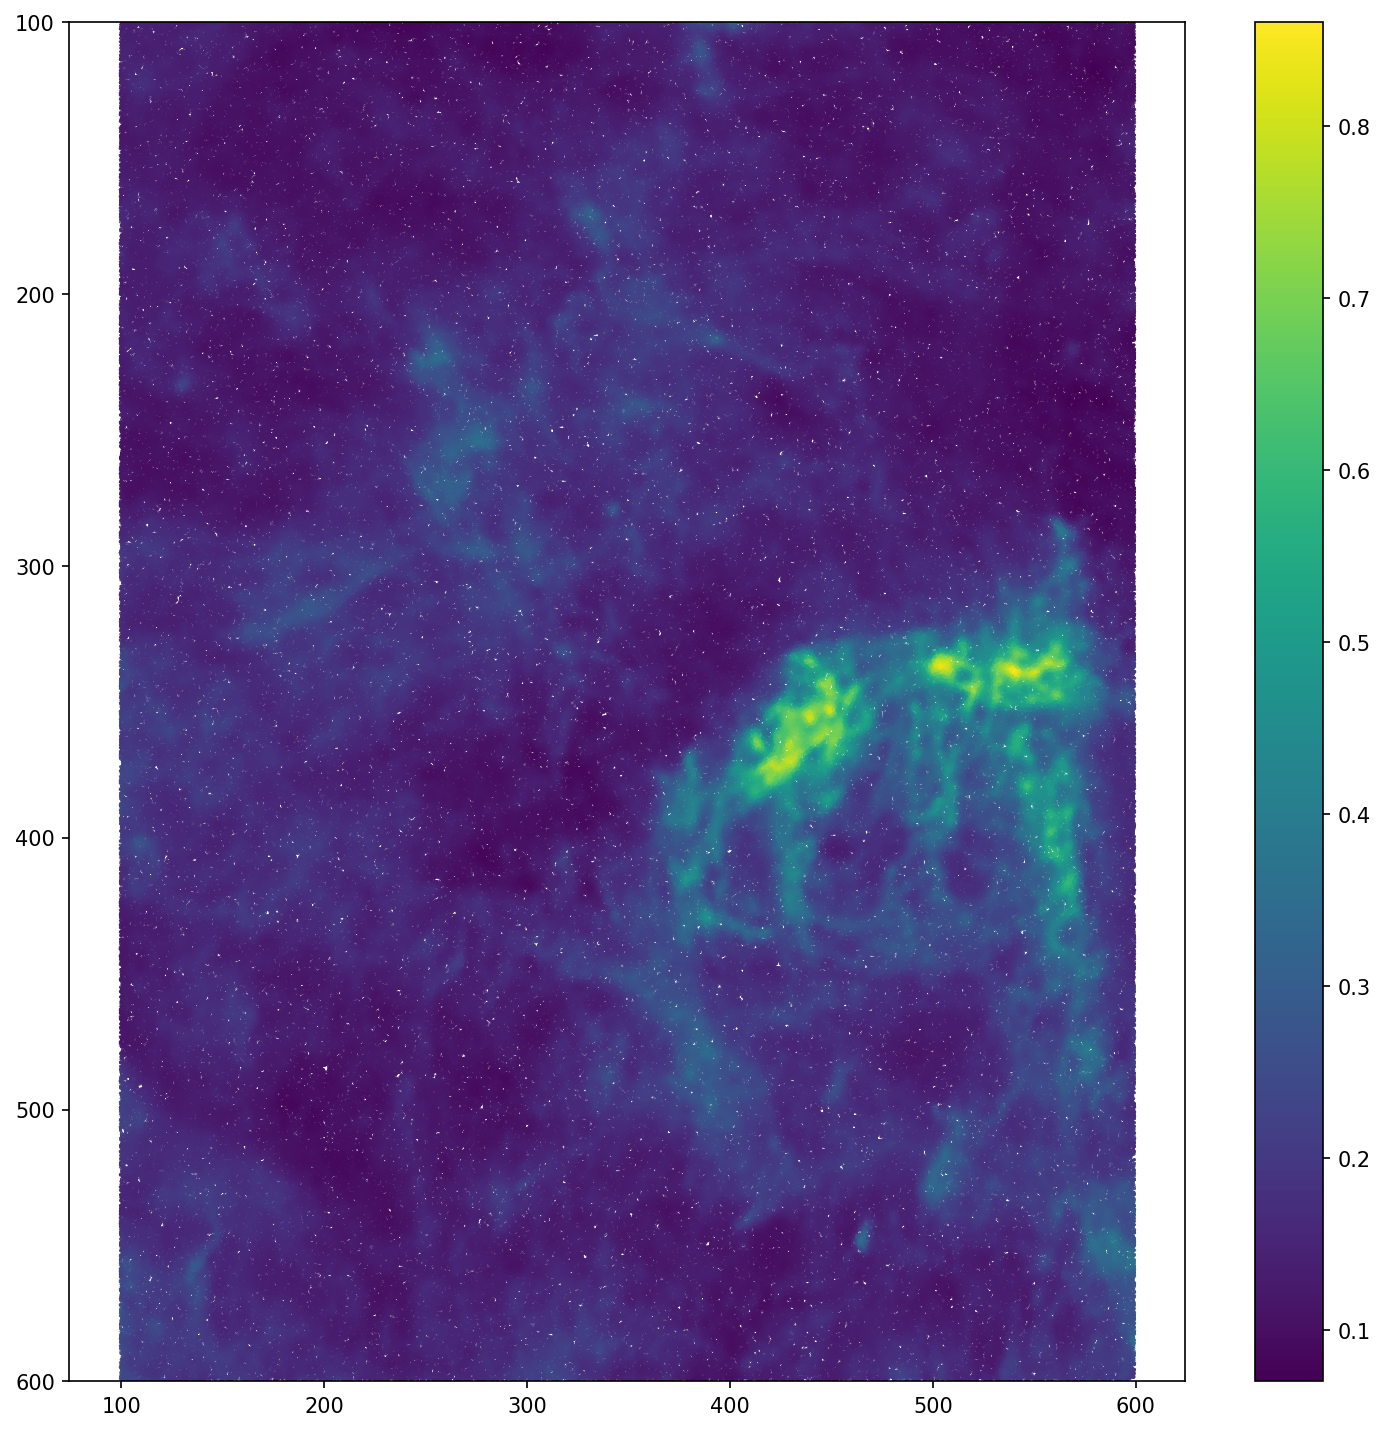

In [4]:
fig = plt.figure(figsize=(12,12), dpi=150)
plt.scatter(data[:, 0], data[:,1], c=data[:, 2], s=0.2)
plt.ylim(600, 100)
plt.colorbar()
plt.show()

## Step 6: Construct benchmark

benchmark_midpoint: the central point of each "big" pixel. There 100*100 big pixels of size 5x5 in the 500x500 image. This is the preferred benchmark.

benchmark_avg: the avg of the $N$ points assigned to each 5*5 section of the 500x500 image, creating a benchmark of size 100x100.

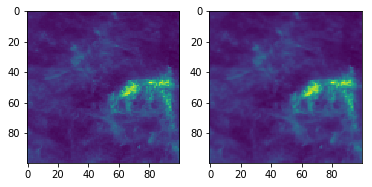

In [5]:
original_trimmed = A[100:600, 100:600]
N1 = len(original_trimmed)
N2 = 100

def make_benchmark(N1,N2,img,mode='mid'):
    size = int(N1 / N2)
    benchmark = np.zeros((N2, N2))
    
    for i in range(0, N1, size):
        row = []
        for j in range(0, N1, size):
            # In this method of the benchmark, take the average of assigned pixels
            if mode=='avg':
                avg = np.mean(original_trimmed[i: i + size, j: j + size].flatten())
                row.append(avg)
            # Otherwise, take midpoint
            elif mode=='mid':    
                mid=img[i + size//2,  j + size//2]
                row.append(mid)
        row = np.array(row)
        benchmark[(i // size)] = row
    return benchmark

plt.subplot(121)
benchmark_midpoint=make_benchmark(N1,N2,original_trimmed,mode='mid')
plt.imshow(benchmark_midpoint)
plt.subplot(122)
benchmark_avg=make_benchmark(N1,N2,original_trimmed,mode='avg')
plt.imshow(benchmark_avg)

## Step 7: Define Figure of Merit (FOM) as RMSE between coarse reconstructed map and benchmark_mid.

RMSE error between two equal-sized figures, disregarding the margin (default=3, since this is the highest Lanczos degree). The reason for disregarding the margin of size $a=3$ is explained in Section 3.2.

In [6]:
def FOM(reconstructed, target, margin=3):
    if margin:
        reconstructed = reconstructed[margin: -margin, margin: -margin]
        target = target[margin: -margin, margin: -margin]
        
    reconstructed = reconstructed.flatten()
    target = target.flatten()
    return np.sqrt(np.mean(np.square(reconstructed-target)))


### Plot the difference (left) and relative difference (right) between the two benchmarks.

FOM between two benchmarks: 0.004718726149458678


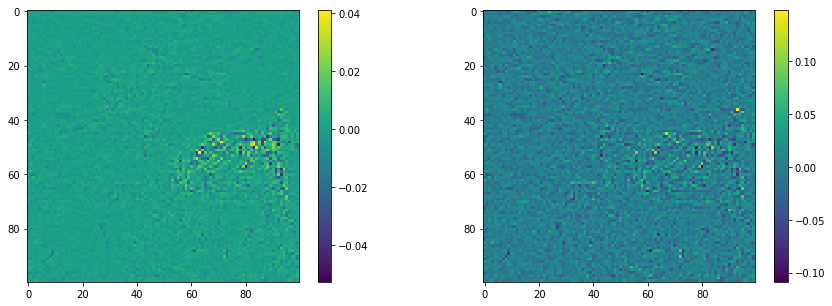

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(benchmark_avg-benchmark_midpoint)
plt.colorbar()
plt.subplot(122)
plt.imshow((benchmark_avg-benchmark_midpoint)/benchmark_midpoint)
plt.colorbar()
print('FOM between two benchmarks:',FOM(benchmark_avg,benchmark_midpoint))

We see some minor disagreements between benchmarks.

## Step 8 Inverse Lanczos Interpolation Method

 Lanczos Interpolation: https://en.wikipedia.org/wiki/Lanczos_resampling
 ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6fb3a373a0292f6f6de5692e8445576239c61eab)

In [156]:
def Lanczos(x, a):
    if x == 0:
        return 1
    elif -a <= x < a and x != 0:
        top = (a * np.sin(np.pi * x) * np.sin(np.pi * x / a))
        bottom = (np.pi ** 2 * x ** 2)
        return top / bottom
    return 0

## Determine section of interest in the sky in pixel coordinates of original 700x700 image.
## Upper left corner of region of interest is at (300, 325).
## Scala data to [0, W] x [0, W] region.
### data_scaled: used for the Lanczos model
### buckets: used for any local optimization techniques, such as least squares polynomial fitting, which considers only the N points assigned to the pixel.

In [243]:
# Rescale (x, y) coordinates in units of [0, 700] to [0, W] for data in region of interest
def rescale(data, width, x_start, y_start):
    # Scaling factor: how many small pixels stored in each big (downsized) pixel
    s = 5 
    d = s // 2

    buckets = [[[] for _ in range(width)] for _ in range(width)]
    data_scaled = []

    for x, y, e in data:
        # Assign point to bucket containing (x, y)
        # Center of first pixel (top left of reconstructed image) is at (x_start, y_start)
        idx_x = int(round((x - (x_start + d)) / s))
        idx_y = int(round((y - (y_start + d)) / s))

        # Store mean values of e for all stars that fall within pixel centered at (xc, yc)
        if 0 <= idx_x < width and 0 <= idx_y < width:
            data_scaled.append([(x - (x_start + d)) / s, (y - (y_start + d)) / s, e])
            buckets[idx_x][idx_y].append([(x - 102) / s, (y - 102) / s, e])
            
    data_scaled = np.array(data_scaled)
    return data_scaled, buckets

# Create Lanczos interpolation matrix A
def lanczos_interpolation(data, a, width):
    num_points = len(data)
    A = np.zeros((num_points, width ** 2))
    E = np.zeros((num_points))
    idx = 0
    
    # Loop over all data points, find corresponding Lanczos kernel terms
    for idx, (x, y, _) in enumerate(data):
        if (idx + 1) % 100000 == 0 and idx != 0: print (idx + 1)
        floor_x = int(np.floor(x))
        floor_y = int(np.floor(y))
        for i in range(floor_x - a + 1, floor_x + 3):
            if 0 <= i <= width - 1:
                for j in range(floor_y - a + 1, floor_y + 3):
                    if 0 <= j <= width - 1:
                        
                        A[idx, width * i + j] = Lanczos(x - i, a) * Lanczos(y - j, a)
     
    E = data[:, 2]
    q = np.matmul(np.linalg.pinv(A), E)
    return q

# Take in dataset and desired region of sky
# Reconstruct map using inverse Lanczos interpolation
def reconstruct_and_compare(data, width, x_start, y_start, a, size=5, plot_results=True, return_map=False):
    data_scaled = rescale(data, width, y_start, x_start)[0]

    # Benchmark
    small = A[x_start: x_start + width * size, y_start: y_start + width * size]
    N1, N2 = small.shape
    N2=N1//size
    benchmark = make_benchmark(N1,N2,small,mode='mid')

    # Get interpolated image
    preds = lanczos_interpolation(data_scaled, a, width)
    img = np.reshape(preds, [width, width])

    # Rotate image
    rotated = np.zeros((width, width))
    for i in range(width):
        for j in range(width):
            rotated[i][width - j - 1] = img[i][j]

    rotated = np.rot90(rotated)     
    fom = FOM(rotated, benchmark)
    print ("FOM: {}".format(fom))
    
    # Plot results and residue map
    if plot_results:
        fig = plt.figure(figsize=(12,4), dpi=150)
        plt.subplot(121)
        plt.imshow(rotated, interpolation='none',vmin=0.08,vmax=.67)
        plt.colorbar()

        plt.subplot(122)
        plt.imshow(rotated-benchmark, interpolation='none',vmin=-0.21,vmax=0.21)
        plt.ylabel('residue')
        plt.colorbar()  
    return fom, rotated if return_map else fom
    

In [165]:
# Store error results per N points per pixel for each margin size 
def generate_lanczos_errors(dataset, min_points, max_points, a_range, x_start, y_start, width):
    margin_errors = [[] for _ in range(len(a_range))]
    img_width = 100

    for i, n_points_per_pixel in enumerate(range(min_points, max_points + 1)):
        np.random.seed(100)
        indexset=np.random.choice(img_width**3,size=n_points_per_pixel*img_width**2,replace=False)
        print ("n: {}".format(n_points_per_pixel))
        width = 30
        for i, margin_val in enumerate(a_range):
            err_mid = reconstruct_and_compare(dataset[indexset], width, x_start, y_start, margin_val, plot_results=False)
            margin_errors[i].append(err_mid)

    return np.array(margin_errors)

In [238]:
def plot_error_results(errors, min_points, max_points, method, labels, offset=0, min_n=3, noise=''):
    log_data = np.log10(errors)
    interval = np.array([min_n + i for i in range(max_points - min_n + 1)])[offset:]

    # Plot errors on loglog scale
    fig = plt.figure()
    ax = plt.subplot(111)    
   
    for i in range(len(errors)):
        ax.plot(np.log10(interval), log_data[i], label=labels[i])
    plt.ylabel(r'$\log_{10}(RMSE)$')
    plt.xlabel(r'$\log_{10} N$, $N$ samples per pixel')
    plt.title(r'$\log_{10}(RMSE)$ of %s vs. $\log_{10}N$' % (method))
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
    
    if noise:
        method = method.split()[0]    
    plt.savefig('{}-errors-{}-to-{}{}.png'.format(method, min_points, max_points, noise))  
    plt.show()
    

In [167]:
def get_lanczos_results(data):
    min_points = 3
    max_points = 50
    a_range = [1, 2, 3]
    # Note that x_start and y_start are reversed during rescaling
    x_start = 325
    y_start = 300
    width = 30
    
    lanczos_errors = generate_lanczos_errors(data, min_points, max_points, a_range, x_start, y_start, width)
    return lanczos_errors

In [168]:
lanczos_errors = get_lanczos_results(data)

n: 3
FOM: 0.21149962535328057
FOM: 0.01647536191252048
FOM: 0.019620392451065543
n: 4
FOM: 0.08421532588215007
FOM: 0.0136595562049204
FOM: 0.018070832053868658
n: 5
FOM: 0.07468562542666841
FOM: 0.012288168836943983
FOM: 0.016268674667741685
n: 6
FOM: 0.0691024820559351
FOM: 0.011570302817216662
FOM: 0.01542657971065377
n: 7
FOM: 0.06554736852483142
FOM: 0.011309023969561289
FOM: 0.014643094370228201
n: 8
FOM: 0.06429133781063019
FOM: 0.010934759160314018
FOM: 0.014394751405894503
n: 9
FOM: 0.0627347763397159
FOM: 0.010432420118691124
FOM: 0.013963476309235865
n: 10
FOM: 0.062014949803147
FOM: 0.010297316422123039
FOM: 0.01390410285507277
n: 11
FOM: 0.06149831094684195
FOM: 0.010075644116424547
FOM: 0.01366396248846697
n: 12
FOM: 0.06192616974604034
FOM: 0.009989415262796881
FOM: 0.013795080013781177
n: 13
FOM: 0.061993284476355465
FOM: 0.009933606258360952
FOM: 0.013749204572664918
n: 14
FOM: 0.06171657296468487
FOM: 0.009759609227173867
FOM: 0.013685338430954576
n: 15
FOM: 0.0612974

In [171]:
with open("lanczos-a=1,2,3-n=3-50.pickle","wb") as f:
    pickle.dump(lanczos_errors, f)

In [172]:
with open("lanczos-a=1,2,3-n=3-50.pickle","rb") as f:
    loaded_lanczos_errors = pickle.load(f)
print (loaded_lanczos_errors.shape)

(3, 48)


## Print results for selected values of N

In [225]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(3):
    print ("\nLanczos(no noise) a={}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(lanczos_errors[deg][i - start]))


Lanczos(no noise) a=1
n = 3
log base 10 (RMSE) = 0.21149962535328057
n = 6
log base 10 (RMSE) = 0.0691024820559351
n = 10
log base 10 (RMSE) = 0.062014949803147
n = 20
log base 10 (RMSE) = 0.06055444519875061
n = 30
log base 10 (RMSE) = 0.05970411218016965
n = 40
log base 10 (RMSE) = 0.05916428221986341
n = 50
log base 10 (RMSE) = 0.058729523472628296

Lanczos(no noise) a=2
n = 3
log base 10 (RMSE) = 0.01647536191252048
n = 6
log base 10 (RMSE) = 0.011570302817216662
n = 10
log base 10 (RMSE) = 0.010297316422123039
n = 20
log base 10 (RMSE) = 0.009409783106821482
n = 30
log base 10 (RMSE) = 0.009298047606078302
n = 40
log base 10 (RMSE) = 0.009017166819311358
n = 50
log base 10 (RMSE) = 0.008787906383424846

Lanczos(no noise) a=3
n = 3
log base 10 (RMSE) = 0.019620392451065543
n = 6
log base 10 (RMSE) = 0.01542657971065377
n = 10
log base 10 (RMSE) = 0.01390410285507277
n = 20
log base 10 (RMSE) = 0.01359456315985414
n = 30
log base 10 (RMSE) = 0.013227892516088096
n = 40
log base 10 

### Plot inverse Lanczos interpolation results (no noise)

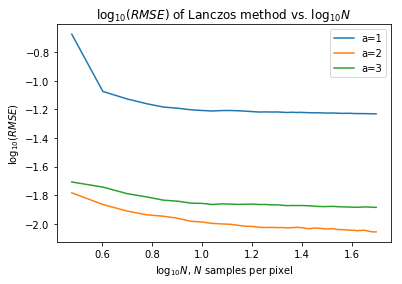

In [216]:
labels = ['a=1', 'a=2', 'a=3']
min_points = 3
max_points = 50
plot_error_results(lanczos_errors, min_points, max_points, 'Lanczos', labels)

## Step 9a: Bucket data points to corresponding pixels of size 5x5 within the inner 500x500 image. Alternatively, skip to Step 9b and load the bucketed data.

In [ ]:
buckets = rescale(data, 100, 100, 100)[1]

## Step 9b: Alternatively, load the bucketed data.

In [ ]:
with open("bucketed_data_100x100.pickle","rb") as f:
    buckets = pickle.load(f)

## Step 10: Try other methods (Polynomial 2d least squares and Chebyshev 2d least squares)

Use bucketed data "bucketed_data_100x100.pickle" from previous work on project. The buckets refer to "bucketing" all data points within a 5x5 square of a larger 500x500 image and using them to determine the value of a corresponding single pixel in a new 100x100 image.

In [283]:
# Interpolation scheme
from scipy.interpolate import interp2d, Rbf

# 2D Chebyshev least squares fitting
def chebyshev2d(xs, ys, zs, xc, yc, degree):
    degree = int(degree)
    deg = [degree, degree]
    xs = (xs - xc) / 0.5
    ys = (ys - yc) / 0.5
    A = chebvander2d(xs, ys, deg=deg)
    c_ijs = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T), zs)
    c_ijs = c_ijs.reshape(degree + 1, degree + 1)
    value = chebval2d(0, 0, c_ijs)
    return value

# 2D polynomial least squares fitting
def polynomial2d(xs, ys, zs, xc, yc, degree):
    degree = int(degree)
    deg = [degree, degree]
    xs = (xs - xc) / 0.5
    ys = (ys - yc) / 0.5
    A = polyvander2d(xs, ys, deg)
    c_ijs = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T), zs)
    c_ijs = c_ijs.reshape(degree + 1, degree + 1)
    value = polyval2d(0, 0, c_ijs)
    return value
 
# Bilinear interpolation
def interpolate(xs, ys, zs):
    return interp2d(xs, ys, zs)

# Reconstruction methods (not necessarily all interpolation)
def interp_method(xc, yc, temp_data, method):
    temp_data = np.array(temp_data)
    xs, ys, zs = temp_data[:, 0], temp_data[:, 1], temp_data[:, 2]
    # Method 1: Average all stars inside pixel centered at (xc, yc)
    if method == 'avg':
        return np.mean(zs)
    
    elif method == 'interpolate':
        return interp2d(xs, ys, zs, kind='linear')
    
    elif method == 'rbf_cubic':
        return Rbf(xs, ys, zs, function='cubic')

    elif method == 'rbf_linear':
        return Rbf(xs, ys, zs, function='linear')    
    
    elif method == 'rbf_gaussian':
        return Rbf(xs, ys, zs, function='gaussian')
    
    elif method == 'thin_plate':
        return Rbf(xs, ys, zs, function='thin_plate')
    
    elif 'chebyshev2d' in method:
        degree = method[-1]
        return chebyshev2d(xs, ys, zs, xc, yc, degree)
    
    elif 'polynomial2d' in method:
        degree = method[-1]
        return polynomial2d(xs, ys, zs, xc, yc, degree)        

# Locally reconstruct image using N points assigned to each pixel in the final image
def reconstruct(buckets, method, x_start, y_start, size=5, ptspp=100, plot_results=True, degree=1):
    reconstructed = np.zeros((100, 100))
    start = time.time()
    for xc in range(100):
        for yc in range(100):
            region_data = np.array(buckets[xc][yc])
            if ptspp <= 100:
                np.random.seed(100)
                indexset=np.random.choice(len(region_data),size=len(region_data)*ptspp//100,replace=False)
                region_data=region_data[indexset]
            else:
                raise ValueError("Cannot use more than the maximum number of sample points in dataset.")
            if region_data != []:
                if method in ['interpolate', 'rbf_cubic', 'rbf_linear', 'rbf_gaussian', 'thin_plate']:
                    f = interp_method(xc, yc, region_data, method)
                    reconstructed[xc][yc] = f(xc, yc)
                else:
                    reconstructed[xc, yc] = interp_method(xc, yc, region_data, method)
    
    # Rotate image
    rotated = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            rotated[i][100 - j - 1] = reconstructed[i][j]

    rotated = np.rot90(rotated)
    
    # Select region of interest within 100x100 reconstructed image. 
    # For the research paper, this is a 30x30 region of interest.
    x_small, y_small = 45, 40
    rotated_focus = rotated[x_small:x_small + width, y_small:y_small + width]
    
    # Benchmark
    small = A[x_start: x_start + width * size, y_start: y_start + width * size]
    N1, N2 = small.shape
    N2=N1//size
    benchmark = make_benchmark(N1,N2,small,mode='mid')
    
    fom = FOM(rotated_focus, benchmark)
    print ("FOM: {}".format(fom))
 
    if plot_results:
        fig = plt.figure(figsize=(12,4), dpi=150)
        plt.subplot(121)
        plt.imshow(rotated_focus, interpolation='none',vmin=0.08,vmax=.67)
        plt.colorbar()
        plt.ylabel('Reconstruction: {} deg={}'.format(method[:-1], degree))

        plt.subplot(122)
        plt.imshow(rotated_focus-benchmark, interpolation='none',vmin=-0.21,vmax=0.21)
        plt.ylabel('Relative Error')
        plt.colorbar()    
        plt.savefig('polyfit2d-reconstruction-ptspp={}deg={}'.format(ptspp, degree))
    return fom

### 2d polynomial fit of degree 1, 2, 3, 4 vs. number of points per pixel. The difference between theoretical and experimental values of the lower bound of N for a polynomial of degree m is explained in Section 5.3. In theory, for a degree m polynomial, each pixel requires $N \geq (m+1)^2$ points.

Degree 1 requires at least 6 points per pixel. Theoretical: 4.

Degree 2 requires at least 11 points per pixel. Theoretical: 9.

Degree 3 requires at least 19 points per pixel. Theoretical: 16.

Degree 4 requires at least 32 points per pixel. Theoretical: 25.

In [78]:
# Calculate polynomial and chebyshev fitting errors
# Populate values where N is lower than threshold with nan to provide clean plot
def generate_poly_or_cheb_errors(buckets, min_points, max_points, degree_range, thresh, x_start, y_start, width, method_name, min_n=3):
    method_errors = np.zeros((len(degree_range), max_points - min_n + 1))
    
    # Append None's from 2 to threshold where degree can't fit singular matrix
    for i in range(len(method_errors)):
        if (i + 1) == 1:
            for j in range(thresh[i] - min_n):
                method_errors[i][j] = None
        elif (i + 1) == 2:
            for j in range(thresh[i] - min_n):
                method_errors[i][j] = None
        elif (i + 1) == 3:
            for j in range(thresh[i] - min_n):
                method_errors[i][j] = None
        else:
            for j in range(thresh[i] - min_n):
                method_errors[i][j] = None
    
    for i, deg in enumerate(degree_range):
        print ("{} method with degree {}".format(method_name, deg))
        method = '{}{}'.format(method_name, deg)

        for n in range(thresh[i], max_points + 1):
            print ("n: {}".format(n))
            try:
                err_mid = reconstruct(buckets, method, x_start, y_start, ptspp=n, plot_results=False)
                method_errors[i][n - min_n] = err_mid
            except KeyboardInterrupt:
                raise ValueError('quitting')
            except:
                print ("Found singular matrix.")
                method_errors[i][n - min_n] = None
            
    return np.array(method_errors)


In [123]:
def get_poly_results(buckets):
    poly_degree_range = [1, 2, 3, 4]
    min_points = 6
    max_points = 50
    x_start, y_start = 325, 300
    width = 30
    method_name = 'polynomial2d'
    thresh_1 = 6
    thresh_2 = 11
    thresh_3 = 19
    thresh_4 = 32
    thresh = [thresh_1, thresh_2, thresh_3, thresh_4]    
    
    polyfit_errors = generate_poly_or_cheb_errors(buckets, min_points, max_points, poly_degree_range, thresh, x_start, y_start, width, method_name)
    return polyfit_errors

In [ ]:
polyfit_errors = get_poly_results(buckets)

In [ ]:
print ("errors:\n{}".format(polyfit_errors))

In [85]:
with open ('polyfit2d-errors-n=3-50.pickle', 'wb') as f:
    pickle.dump(polyfit_errors, f)

In [86]:
with open ('polyfit2d-errors-n=3-50.pickle', 'rb') as f:
    loaded_polyfit_errors = pickle.load(f)
print (loaded_polyfit_errors.shape)

(4, 48)


### Polynomial 2d fitting (no noise)

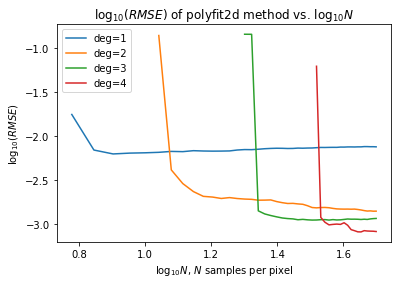

In [217]:
poly_degree_range = [1, 2, 3, 4]
labels = ['deg={}'.format(i) for i in poly_degree_range]
min_points = 6
max_points = 50

plot_error_results(loaded_polyfit_errors, min_points, max_points, 'polyfit2d', labels)

## Plot Lanczos and Polyfit2d on same plot for Lanczos a=1,2,3 and polyfit2d deg=1,2,3,4

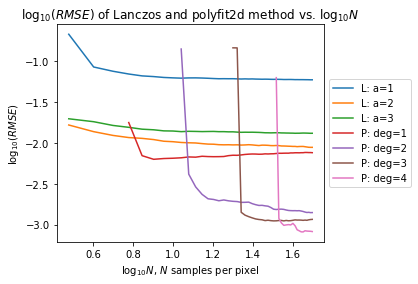

In [228]:
min_points = 3
max_points = 50
labels = ['L: a=1', 'L: a=2', 'L: a=3', 'P: deg=1', 'P: deg=2', 'P: deg=3', 'P: deg=4']
lanczos_and_polyfit_errors = np.vstack((loaded_lanczos_errors, loaded_polyfit_errors))
plot_error_results(lanczos_and_polyfit_errors, min_points, max_points, 'Lanczos and polyfit2d', labels)

## Chebyshev 2d

In [133]:
def get_cheb_results(buckets):
    cheb_degree_range = [1, 2, 3, 4]
    min_points = 6
    max_points = 50
    x_start, y_start = 325, 300
    width = 30
    method_name = 'chebyshev2d'
    thresh_1 = 6
    thresh_2 = 12
    thresh_3 = 22
    thresh_4 = 29
    thresh = [thresh_1, thresh_2, thresh_3, thresh_4]    
    
    cheb_errors = generate_poly_or_cheb_errors(buckets, min_points, max_points, cheb_degree_range, thresh, x_start, y_start, width, method_name)
    return cheb_errors

In [ ]:
cheb_errors = get_cheb_results()
print (cheb_errors)

In [ ]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(4):
    print ("\nPolyfit2d degree {}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(polyfit_errors[deg][i - start]))

### Chebyshev 2d fitting (no noise)

In [100]:
with open("chebyshev2d_deg=1,2,3,4_n=2-50.pickle","wb") as f:
    pickle.dump(cheb_errors, f)

In [101]:
with open("chebyshev2d_deg=1,2,3,4_n=2-50.pickle","rb") as f:
    loaded_cheb_errors = pickle.load(f)
print (loaded_cheb_errors.shape)

(4, 48)


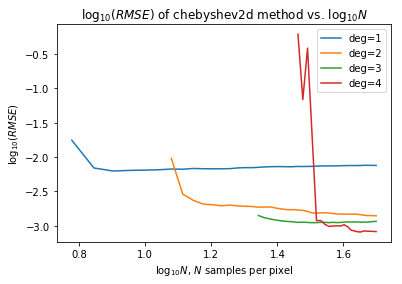

In [218]:
cheb_degree_range = [1, 2, 3, 4]
labels = ['deg={}'.format(i) for i in cheb_degree_range]
min_points = 6
max_points = 50

plot_error_results(cheb_errors, min_points, max_points, 'chebyshev2d', labels)

## Step 11a: Get Noisy Data. 
### We get the noisy data by multiplying each extinction value by an epsilon drawn from a Normal distribution. The first Normal is N(1,0.05^2), and the second Normal is N(1,0.30^2). This allows for relative scaling (multiplying by Normal centered at 1), as explained in Section 6 of the report.

## Alternatively, load noisy data in Step 11b.

In [ ]:
# Add noise to dataset.
# Scale by N(1, 0.05^2), causing relative error of N(0, 0.05^2).
np.random.seed(12345)
from numpy.random import normal
noise=normal(1,.05,len(data))
noisy_data_05=np.array([[x,y,e*noise[i]] for i, (x,y,e) in enumerate(data)])

In [ ]:
# Add noise to dataset. 
# Scale by N(1, 0.30^2), causing relative error of N(0, 0.30^2).
np.random.seed(12345)
noise=normal(1,.30,len(data))
noisy_data_30=np.array([[x,y,e*noise[i]] for i, (x,y,e) in enumerate(data)])

## Step 11b: Load noisy data from hard drive.

In [119]:
with open('data-mult-N(1,0.05)-1m.pickle', 'rb') as f:
    noisy_data_05 = pickle.load(f)
print (noisy_data_05.shape)

(1000000, 3)


In [120]:
with open('data-mult-N(1,0.30)-1m.pickle', 'rb') as f:
    noisy_data_30 = pickle.load(f)
print (noisy_data_30.shape)

(1000000, 3)


In [121]:
noisy_buckets_05 = rescale(noisy_data_05, 100, 100, 100)[1]
noisy_buckets_30 = rescale(noisy_data_30, 100, 100, 100)[1]
print (len(noisy_buckets_05))
print (len(noisy_buckets_30))

100
100


## Step 12: Apply methods to data with relative error of $N(0, 0.05^2)$ and $N(0, 0.30^2)$. Print selected results over the range N=3,...,50 and plot errors.

## Fit noisy Lanczos

In [183]:
noisy_05_lanczos_errors = get_lanczos_results(noisy_data_05)

n: 3
FOM: 0.3722068415078932
FOM: 0.02516430314211005
FOM: 0.02277064906716237
n: 4
FOM: 0.08593294975863314
FOM: 0.017356797778129388
FOM: 0.019942422472403208
n: 5
FOM: 0.07476721267096557
FOM: 0.014980998321678256
FOM: 0.017759619090922038
n: 6
FOM: 0.06960874739632375
FOM: 0.013921302237900553
FOM: 0.016975015960404766
n: 7
FOM: 0.0663860247716266
FOM: 0.013123227979634382
FOM: 0.016081605309209736
n: 8
FOM: 0.06522385279975024
FOM: 0.01254644157987204
FOM: 0.015905148342454944
n: 9
FOM: 0.06384238971221513
FOM: 0.011921361962529872
FOM: 0.015314367861238052
n: 10
FOM: 0.06287957781941443
FOM: 0.011939222339641377
FOM: 0.015151354579616102
n: 11
FOM: 0.06251355200596484
FOM: 0.011660425127573038
FOM: 0.01490118163953131
n: 12
FOM: 0.06264405758971474
FOM: 0.01166910752757678
FOM: 0.014754395556385044
n: 13
FOM: 0.0626830091073975
FOM: 0.011483382028846611
FOM: 0.014646198226335555
n: 14
FOM: 0.06222509860907161
FOM: 0.011108590130719272
FOM: 0.014504941450182506
n: 15
FOM: 0.061703

In [192]:
print ("noisy 05 Lanczos errors:\n{}".format(noisy_05_lanczos_errors))

noisy 05 Lanczos errors:
[[0.37220684 0.08593295 0.07476721 0.06960875 0.06638602 0.06522385
  0.06384239 0.06287958 0.06251355 0.06264406 0.06268301 0.0622251
  0.06170381 0.0612248  0.06074367 0.06092086 0.060703   0.06069188
  0.06044389 0.06018541 0.06041445 0.06029165 0.06043796 0.06009931
  0.06002328 0.05985739 0.05988632 0.05980853 0.05968676 0.05964946
  0.05977169 0.05961561 0.05956083 0.0594374  0.05949136 0.05953724
  0.05948522 0.05946821 0.05928263 0.0593142  0.05924161 0.05926449
  0.05926904 0.05922124 0.05916932 0.05910139 0.05897835 0.05896954]
 [0.0251643  0.0173568  0.014981   0.0139213  0.01312323 0.01254644
  0.01192136 0.01193922 0.01166043 0.01166911 0.01148338 0.01110859
  0.01085767 0.01075875 0.01078535 0.01061515 0.01060123 0.0104959
  0.01044612 0.01038308 0.01035334 0.01043902 0.01039369 0.01022398
  0.0101165  0.01008669 0.01004741 0.01004449 0.00988777 0.00979651
  0.00983223 0.00970887 0.00958641 0.00957007 0.00956254 0.00949677
  0.00953415 0.00940481 

In [187]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(3):
    print ("\nLanczos noise N(1, 0.05^2) a={}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(noisy_05_lanczos_errors[deg][i - start]))


Lanczos noise N(1, 0.05^2) a=1
n = 3
log base 10 (RMSE) = 0.3722068415078932
n = 6
log base 10 (RMSE) = 0.06960874739632375
n = 10
log base 10 (RMSE) = 0.06287957781941443
n = 20
log base 10 (RMSE) = 0.060691878129846645
n = 30
log base 10 (RMSE) = 0.05980852785521225
n = 40
log base 10 (RMSE) = 0.05946820938746572
n = 50
log base 10 (RMSE) = 0.05896953889786244

Lanczos noise N(1, 0.05^2) a=2
n = 3
log base 10 (RMSE) = 0.02516430314211005
n = 6
log base 10 (RMSE) = 0.013921302237900553
n = 10
log base 10 (RMSE) = 0.011939222339641377
n = 20
log base 10 (RMSE) = 0.010495903726016186
n = 30
log base 10 (RMSE) = 0.01004448766036553
n = 40
log base 10 (RMSE) = 0.009404806561126449
n = 50
log base 10 (RMSE) = 0.00905158625124242

Lanczos noise N(1, 0.05^2) a=3
n = 3
log base 10 (RMSE) = 0.02277064906716237
n = 6
log base 10 (RMSE) = 0.016975015960404766
n = 10
log base 10 (RMSE) = 0.015151354579616102
n = 20
log base 10 (RMSE) = 0.014238546424528062
n = 30
log base 10 (RMSE) = 0.013695982

In [184]:
noisy_30_lanczos_errors = get_lanczos_results(noisy_data_30)

n: 3
FOM: 3.068836496081741
FOM: 0.11026889447900416
FOM: 0.07745500780618696
n: 4
FOM: 0.1290992716340738
FOM: 0.06843434705898686
FOM: 0.06262155439916132
n: 5
FOM: 0.09779738734295165
FOM: 0.05470374810141715
FOM: 0.05161802824393976
n: 6
FOM: 0.08835355202676876
FOM: 0.047294039323867214
FOM: 0.04577243552802483
n: 7
FOM: 0.0854363436753711
FOM: 0.0424753671723576
FOM: 0.04128020454376249
n: 8
FOM: 0.08367849413993027
FOM: 0.041041417410598746
FOM: 0.04041427099247773
n: 9
FOM: 0.08211265167815002
FOM: 0.03863762992618372
FOM: 0.03801602424145905
n: 10
FOM: 0.07933752671459011
FOM: 0.03770122706945258
FOM: 0.036450212171957666
n: 11
FOM: 0.07867693638256536
FOM: 0.036473334323705794
FOM: 0.03543249575056625
n: 12
FOM: 0.07660022037395485
FOM: 0.0351929686011652
FOM: 0.03347223671779419
n: 13
FOM: 0.07599973431029881
FOM: 0.03406412234728082
FOM: 0.03258384887917563
n: 14
FOM: 0.07361824181595437
FOM: 0.03228204040663853
FOM: 0.03125995729705463
n: 15
FOM: 0.0725388673592373
FOM: 0.

In [191]:
print ("noisy 30 Lanczos errors:\n{}".format(noisy_30_lanczos_errors))

noisy 30 Lanczos errors:
[[3.0688365  0.12909927 0.09779739 0.08835355 0.08543634 0.08367849
  0.08211265 0.07933753 0.07867694 0.07660022 0.07599973 0.07361824
  0.07253887 0.07092713 0.0695007  0.06957604 0.06832236 0.06767855
  0.06705905 0.0665103  0.06663427 0.06687212 0.06661999 0.0656107
  0.06568494 0.06502789 0.06447526 0.06413269 0.06425871 0.06422604
  0.06407557 0.06369176 0.06331515 0.06329399 0.06351655 0.06358271
  0.06316427 0.06347741 0.06311263 0.063043   0.06278499 0.06272785
  0.06281317 0.0627847  0.06251936 0.06234981 0.06214948 0.06198232]
 [0.11026889 0.06843435 0.05470375 0.04729404 0.04247537 0.04104142
  0.03863763 0.03770123 0.03647333 0.03519297 0.03406412 0.03228204
  0.03187681 0.03043655 0.03013368 0.0291863  0.02828164 0.02744367
  0.02679199 0.02638351 0.02606135 0.02608225 0.02534837 0.02458018
  0.024342   0.02328824 0.02267226 0.02235518 0.02207172 0.02138808
  0.02108313 0.02066678 0.0195628  0.01937137 0.01919449 0.01898007
  0.0189928  0.01850611

In [188]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(3):
    print ("\nLanczos noise N(1, 0.30^2) a={}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(noisy_30_lanczos_errors[deg][i - start]))


Lanczos noise N(1, 0.30^2) a=1
n = 3
log base 10 (RMSE) = 3.068836496081741
n = 6
log base 10 (RMSE) = 0.08835355202676876
n = 10
log base 10 (RMSE) = 0.07933752671459011
n = 20
log base 10 (RMSE) = 0.06767855389688583
n = 30
log base 10 (RMSE) = 0.0641326930548033
n = 40
log base 10 (RMSE) = 0.06347741417367316
n = 50
log base 10 (RMSE) = 0.06198231998924953

Lanczos noise N(1, 0.30^2) a=2
n = 3
log base 10 (RMSE) = 0.11026889447900416
n = 6
log base 10 (RMSE) = 0.047294039323867214
n = 10
log base 10 (RMSE) = 0.03770122706945258
n = 20
log base 10 (RMSE) = 0.02744367462496049
n = 30
log base 10 (RMSE) = 0.022355183085803646
n = 40
log base 10 (RMSE) = 0.01850610804169751
n = 50
log base 10 (RMSE) = 0.016134549719031836

Lanczos noise N(1, 0.30^2) a=3
n = 3
log base 10 (RMSE) = 0.07745500780618696
n = 6
log base 10 (RMSE) = 0.04577243552802483
n = 10
log base 10 (RMSE) = 0.036450212171957666
n = 20
log base 10 (RMSE) = 0.02731827907472284
n = 30
log base 10 (RMSE) = 0.023130839732157

In [194]:
with open('lanczos-errors-data-mult-N(1,0.05^2)-1m.pickle', 'wb') as f:
    pickle.dump(noisy_05_lanczos_errors, f)

In [195]:
with open('lanczos-errors-data-mult-N(1,0.30^2)-1m.pickle', 'wb') as f:
    pickle.dump(noisy_30_lanczos_errors, f)

In [231]:
with open('lanczos-errors-data-mult-N(1,0.05^2)-1m.pickle', 'rb') as f:
    loaded_noisy_05_lanczos_errors = pickle.load(f)

In [232]:
with open('lanczos-errors-data-mult-N(1,0.30^2)-1m.pickle', 'rb') as f:
    loaded_noisy_30_lanczos_errors = pickle.load(f)

## Fit noisy polynomial

In [ ]:
noisy_05_polyfit_errors = get_poly_results(noisy_buckets_05)

In [ ]:
noisy_30_polyfit_errors = get_poly_results(noisy_buckets_30)

In [126]:
print ("noisy 05 errors:\n{}".format(noisy_05_polyfit_errors))

noisy 05 errors:
[[       nan        nan        nan 0.10567931 0.01648649 0.01212654
  0.01105498 0.01034213 0.00910074 0.00889801 0.00852008 0.00848136
  0.00809659 0.00792599 0.00799048 0.0077845  0.00791303 0.00791405
  0.00784736 0.00788049 0.00791948 0.00791692 0.00795    0.00796727
  0.00791281 0.00789198 0.00792687 0.00782036 0.00784928 0.00784366
  0.00789805 0.00791936 0.00790267 0.00791291 0.0078822  0.00789429
  0.00797587 0.00793858 0.00791572 0.00789668 0.00788769 0.00785736
  0.00787921 0.00793413 0.00790431 0.00787517 0.0079008  0.00783434]
 [       nan        nan        nan        nan        nan        nan
         nan        nan 0.24529033 0.04887411 0.03751742 0.01645679
  0.01356738 0.01256622 0.01096696 0.01015204 0.0092069  0.00852352
  0.00826358 0.0077413  0.00764817 0.00748203 0.00726777 0.00716842
  0.00698859 0.00673724 0.00669963 0.00642902 0.00626711 0.00612259
  0.00610446 0.0060564  0.00591144 0.00586567 0.00572205 0.00562967
  0.00557792 0.00554482 0.0054

In [127]:
print ("noisy 30 errors:\n{}".format(noisy_30_polyfit_errors))

noisy 30 errors:
[[       nan        nan        nan 0.67059655 0.09163359 0.06046732
  0.05231199 0.04696438 0.03771705 0.03478919 0.0305781  0.02829934
  0.02613698 0.02525965 0.02513677 0.02371246 0.02261648 0.02212263
  0.02129129 0.02035749 0.01977985 0.01927929 0.01901864 0.0189875
  0.0186586  0.01854474 0.01834633 0.01756182 0.01742896 0.01702717
  0.01702016 0.01692064 0.01650563 0.01636018 0.01584568 0.01579177
  0.01601627 0.01596659 0.01545779 0.01521792 0.01495303 0.01455665
  0.01459553 0.01448692 0.01422138 0.01383355 0.01382427 0.01352512]
 [       nan        nan        nan        nan        nan        nan
         nan        nan 1.27988104 0.2916624  0.22396761 0.09717611
  0.08031177 0.07459547 0.06512224 0.06018051 0.05408385 0.05054006
  0.04914979 0.04597255 0.04522949 0.04373232 0.04268677 0.04210905
  0.04083087 0.03916656 0.03900116 0.03727469 0.03587731 0.03506751
  0.03515068 0.03502658 0.03391388 0.03353801 0.03272049 0.03206739
  0.03161767 0.03162808 0.03123

In [129]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(4):
    print ("\nPolyfit2d noise N(1, 0.05^2) degree {}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(noisy_05_polyfit_errors[deg][i - start]))


Polyfit2d noise N(1, 0.05^2) degree 1
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = 0.10567931171191616
n = 10
log base 10 (RMSE) = 0.010342127157738173
n = 20
log base 10 (RMSE) = 0.00791404636412519
n = 30
log base 10 (RMSE) = 0.007820363408735775
n = 40
log base 10 (RMSE) = 0.00793858209425337
n = 50
log base 10 (RMSE) = 0.007834341018894372

Polyfit2d noise N(1, 0.05^2) degree 2
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = 0.00852352165341449
n = 30
log base 10 (RMSE) = 0.006429021380612058
n = 40
log base 10 (RMSE) = 0.00554481523212572
n = 50
log base 10 (RMSE) = 0.004525531081910034

Polyfit2d noise N(1, 0.05^2) degree 3
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = 0.15430294548901854
n = 30
log base 10 (RMSE) = 0.008387471658217398
n = 40
log base 10 (RMSE) = 0.006210711424834368
n = 50
log base 10 (RMSE) = 0.0048

In [130]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(4):
    print ("\nPolyfit2d noise N(1, 0.30^2) degree {}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(noisy_30_polyfit_errors[deg][i - start]))


Polyfit2d noise N(1, 0.30^2) degree 1
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = 0.6705965458082855
n = 10
log base 10 (RMSE) = 0.046964377824790446
n = 20
log base 10 (RMSE) = 0.022122630680342516
n = 30
log base 10 (RMSE) = 0.017561819841922725
n = 40
log base 10 (RMSE) = 0.015966594134123352
n = 50
log base 10 (RMSE) = 0.013525121904865059

Polyfit2d noise N(1, 0.30^2) degree 2
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = 0.05054006312166505
n = 30
log base 10 (RMSE) = 0.037274689721682464
n = 40
log base 10 (RMSE) = 0.03162808127373235
n = 50
log base 10 (RMSE) = 0.025521618979989842

Polyfit2d noise N(1, 0.30^2) degree 3
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = 0.3754817109775545
n = 30
log base 10 (RMSE) = 0.0493647643995393
n = 40
log base 10 (RMSE) = 0.03645322091300855
n = 50
log base 10 (RMSE) = 0.0282278

In [131]:
with open('polyfit2d-errors-data-mult-N(1,0.05^2)-1m.pickle', 'wb') as f:
    pickle.dump(noisy_05_polyfit_errors, f)

In [132]:
with open('polyfit2d-errors-data-mult-N(1,0.30^2)-1m.pickle', 'wb') as f:
    pickle.dump(noisy_30_polyfit_errors, f)

In [229]:
with open('polyfit2d-errors-data-mult-N(1,0.05^2)-1m.pickle', 'rb') as f:
    loaded_noisy_05_polyfit_errors = pickle.load(f)

In [230]:
with open('polyfit2d-errors-data-mult-N(1,0.30^2)-1m.pickle', 'rb') as f:
    loaded_noisy_30_polyfit_errors = pickle.load(f)

## Fit noisy Chebyshev

In [ ]:
noisy_05_cheb_errors = get_cheb_results(noisy_buckets_05)

In [ ]:
noisy_30_cheb_errors = get_cheb_results(noisy_buckets_30)

In [146]:
noisy_05_cheb_errors[3][30] = noisy_05_cheb_errors[3][31]
print ("noisy 05 cheb errors:\n{}".format(noisy_05_cheb_errors))

noisy 05 cheb errors:
[[       nan        nan        nan 0.10567931 0.01648649 0.01212654
  0.01105498 0.01034213 0.00910074 0.00889801 0.00852008 0.00848136
  0.00809659 0.00792599 0.00799048 0.0077845  0.00791303 0.00791405
  0.00784736 0.00788049 0.00791948 0.00791692 0.00795    0.00796727
  0.00791281 0.00789198 0.00792687 0.00782036 0.00784928 0.00784366
  0.00789805 0.00791936 0.00790267 0.00791291 0.0078822  0.00789429
  0.00797587 0.00793858 0.00791572 0.00789668 0.00788769 0.00785736
  0.00787921 0.00793413 0.00790431 0.00787517 0.0079008  0.00783434]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan 0.04959788 0.03751742 0.01645679
  0.01356738 0.01256622 0.01096696 0.01015204 0.0092069  0.00852352
  0.00826358 0.0077413  0.00764817 0.00748203 0.00726777 0.00716842
  0.00698859 0.00673724 0.00669963 0.00642902 0.00626711 0.00612259
  0.00610446 0.0060564  0.00591144 0.00586567 0.00572205 0.00562967
  0.00557792 0.00554482 0

In [147]:
noisy_30_cheb_errors[3][30] = noisy_30_cheb_errors[3][31]
print ("noisy 30 cheb errors:\n{}".format(noisy_30_cheb_errors))

noisy 30 cheb errors:
[[           nan            nan            nan 6.70596546e-01
  9.16335882e-02 6.04673182e-02 5.23119940e-02 4.69643778e-02
  3.77170537e-02 3.47891928e-02 3.05781041e-02 2.82993356e-02
  2.61369850e-02 2.52596520e-02 2.51367662e-02 2.37124644e-02
  2.26164787e-02 2.21226307e-02 2.12912936e-02 2.03574940e-02
  1.97798527e-02 1.92792900e-02 1.90186446e-02 1.89874990e-02
  1.86586036e-02 1.85447442e-02 1.83463260e-02 1.75618198e-02
  1.74289639e-02 1.70271719e-02 1.70201615e-02 1.69206433e-02
  1.65056279e-02 1.63601752e-02 1.58456823e-02 1.57917710e-02
  1.60162708e-02 1.59665941e-02 1.54577918e-02 1.52179185e-02
  1.49530287e-02 1.45566456e-02 1.45955273e-02 1.44869217e-02
  1.42213790e-02 1.38335458e-02 1.38242651e-02 1.35251219e-02]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan 2.91747955e-01 2.23967605e-01 9.71761109e-02
  8.03117683e-02 7.45954687e-02 6.51222435e-02 

In [148]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(4):
    print ("\nChebyshev2d noise N(1, 0.05^2) degree {}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(noisy_05_cheb_errors[deg][i - start]))


Chebyshev2d noise N(1, 0.05^2) degree 1
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = 0.10567931171191616
n = 10
log base 10 (RMSE) = 0.010342127157738173
n = 20
log base 10 (RMSE) = 0.00791404636412519
n = 30
log base 10 (RMSE) = 0.007820363408735775
n = 40
log base 10 (RMSE) = 0.00793858209425337
n = 50
log base 10 (RMSE) = 0.007834341018894372

Chebyshev2d noise N(1, 0.05^2) degree 2
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = 0.008523521653415654
n = 30
log base 10 (RMSE) = 0.0064290213806119465
n = 40
log base 10 (RMSE) = 0.005544815232125712
n = 50
log base 10 (RMSE) = 0.004525531081910064

Chebyshev2d noise N(1, 0.05^2) degree 3
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = nan
n = 30
log base 10 (RMSE) = 0.008387471658216237
n = 40
log base 10 (RMSE) = 0.006210711424833762
n = 50
log base 10 (RMSE) = 0.00489867670

In [149]:
indices = [3, 6, 10, 20, 30, 40, 50]
start = 3
for deg in range(4):
    print ("\nChebyshev2d noise N(1, 0.30^2) degree {}".format(deg + 1))
    for i in indices:
        print ("n = {}".format(i))
        print ("log base 10 (RMSE) = {}".format(noisy_30_cheb_errors[deg][i - start]))


Chebyshev2d noise N(1, 0.30^2) degree 1
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = 0.6705965458082855
n = 10
log base 10 (RMSE) = 0.046964377824790446
n = 20
log base 10 (RMSE) = 0.022122630680342516
n = 30
log base 10 (RMSE) = 0.017561819841922725
n = 40
log base 10 (RMSE) = 0.015966594134123352
n = 50
log base 10 (RMSE) = 0.013525121904865059

Chebyshev2d noise N(1, 0.30^2) degree 2
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = 0.05054006312166611
n = 30
log base 10 (RMSE) = 0.037274689721682325
n = 40
log base 10 (RMSE) = 0.03162808127373235
n = 50
log base 10 (RMSE) = 0.02552161897998987

Chebyshev2d noise N(1, 0.30^2) degree 3
n = 3
log base 10 (RMSE) = nan
n = 6
log base 10 (RMSE) = nan
n = 10
log base 10 (RMSE) = nan
n = 20
log base 10 (RMSE) = nan
n = 30
log base 10 (RMSE) = 0.04936476439953909
n = 40
log base 10 (RMSE) = 0.03645322091300796
n = 50
log base 10 (RMSE) = 0.0282278463636374

In [150]:
with open('chebyshev2d-errors-data-mult-N(1,0.05^2)-1m.pickle', 'wb') as f:
    pickle.dump(noisy_05_cheb_errors, f)

In [151]:
with open('chebyshev2d-errors-data-mult-N(1,0.30^2)-1m.pickle', 'wb') as f:
    pickle.dump(noisy_30_cheb_errors, f)

## Plot noisy data results for Lanczos and Polyfit2d on same plot for Lanczos a=1,2,3 and polyfit2d deg=1,2,3,4

### Data multiplied by N(1, 0.05^2), which means the relative error is N(0, 0.05^2)

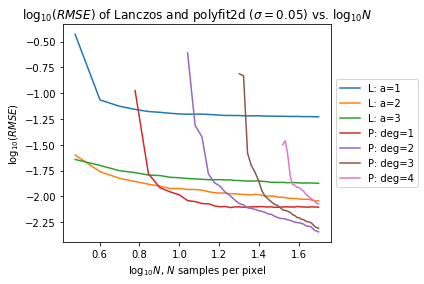

In [241]:
min_points = 3
max_points = 50
labels = ['L: a=1', 'L: a=2', 'L: a=3', 'P: deg=1', 'P: deg=2', 'P: deg=3', 'P: deg=4']
stacked_noisy_05_lanczos_and_polyfit_errors = np.vstack((loaded_noisy_05_lanczos_errors, loaded_noisy_05_polyfit_errors))
plot_error_results(stacked_noisy_05_lanczos_and_polyfit_errors, min_points, max_points, 'Lanczos and polyfit2d ($\sigma=0.05$)', labels)

### Data multiplied by N(1, 0.30^2), which means the relative error is N(0, 0.30^2)

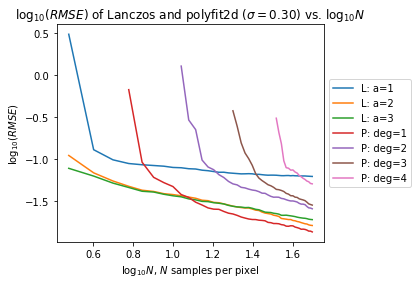

In [242]:
min_points = 3
max_points = 50
labels = ['L: a=1', 'L: a=2', 'L: a=3', 'P: deg=1', 'P: deg=2', 'P: deg=3', 'P: deg=4']
stacked_noisy_30_lanczos_and_polyfit_errors = np.vstack((loaded_noisy_30_lanczos_errors, loaded_noisy_30_polyfit_errors))
plot_error_results(stacked_noisy_30_lanczos_and_polyfit_errors, min_points, max_points, 'Lanczos and polyfit2d ($\sigma=0.30$)', labels)

## Plot results of individual methods on noisy data

### Lanczos fitting with data times N(1, 0.05^2)

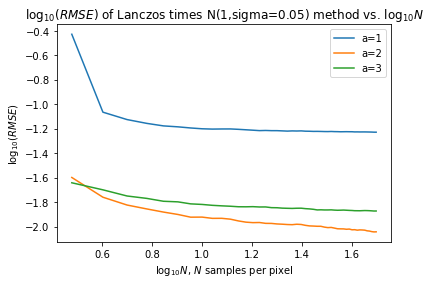

In [219]:
labels = ['a=1', 'a=2', 'a=3']
min_points = 3
max_points = 50

plot_error_results(noisy_05_lanczos_errors, min_points, max_points, 'Lanczos times N(1,sigma=0.05)', labels, noise='sigma=05')

### Lanczos fitting with data times N(1, 0.30^2)

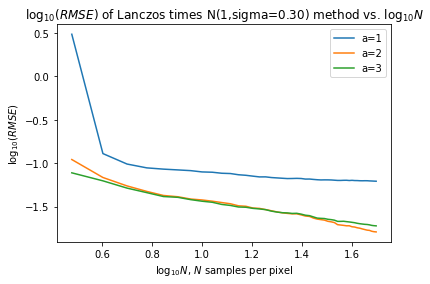

In [220]:
plot_error_results(noisy_30_lanczos_errors, min_points, max_points, 'Lanczos times N(1,sigma=0.30)', labels, noise='sigma=30')

### Polynomial 2d fitting with data times N(1, 0.05^2)

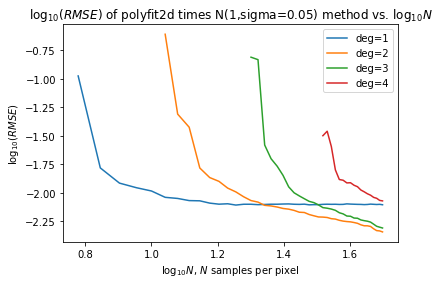

In [221]:
poly_degree_range = [1, 2, 3, 4]
labels = ['deg={}'.format(i) for i in poly_degree_range]
min_points = 6
max_points = 50

plot_error_results(noisy_05_polyfit_errors, min_points, max_points, 'polyfit2d times N(1,sigma=0.05)', labels, noise='sigma=05')

### Polynomial 2d fitting with data times N(1, 0.30^2)

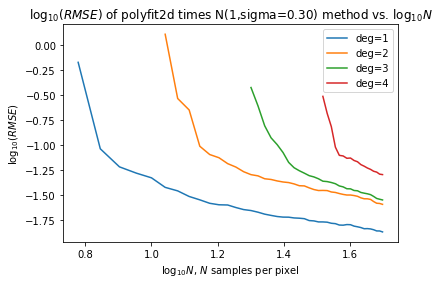

In [222]:
plot_error_results(noisy_30_polyfit_errors, min_points, max_points, 'polyfit2d times N(1,sigma=0.30)', labels, noise='sigma=30')

### Chebyshev 2d fitting with data times N(1, 0.05^2)

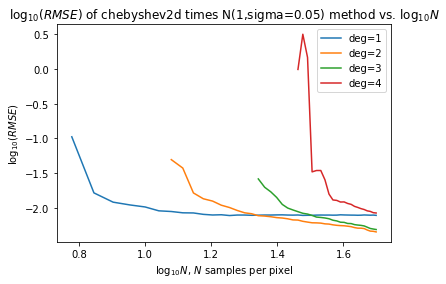

In [223]:
plot_error_results(noisy_05_cheb_errors, min_points, max_points, 'chebyshev2d times N(1,sigma=0.05)', labels, noise='sigma=05')

### Chebyshev 2d fitting with data times N(1, 0.30^2)

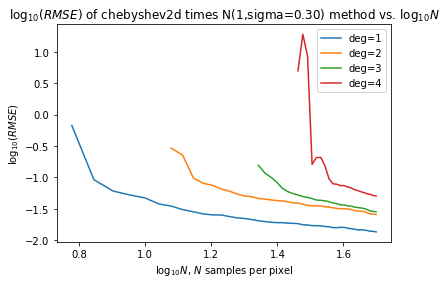

In [224]:
plot_error_results(noisy_30_cheb_errors, min_points, max_points, 'chebyshev2d times N(1,sigma=0.30)', labels, noise='sigma=30')

## Show complete workflow of taking observations, creating the map (equally-spaced grid points), and then smoothing (via Lanczos interpolation). Other examples included in Section 4.5.

points per pix: 10.0
FOM: 0.010297316422123039


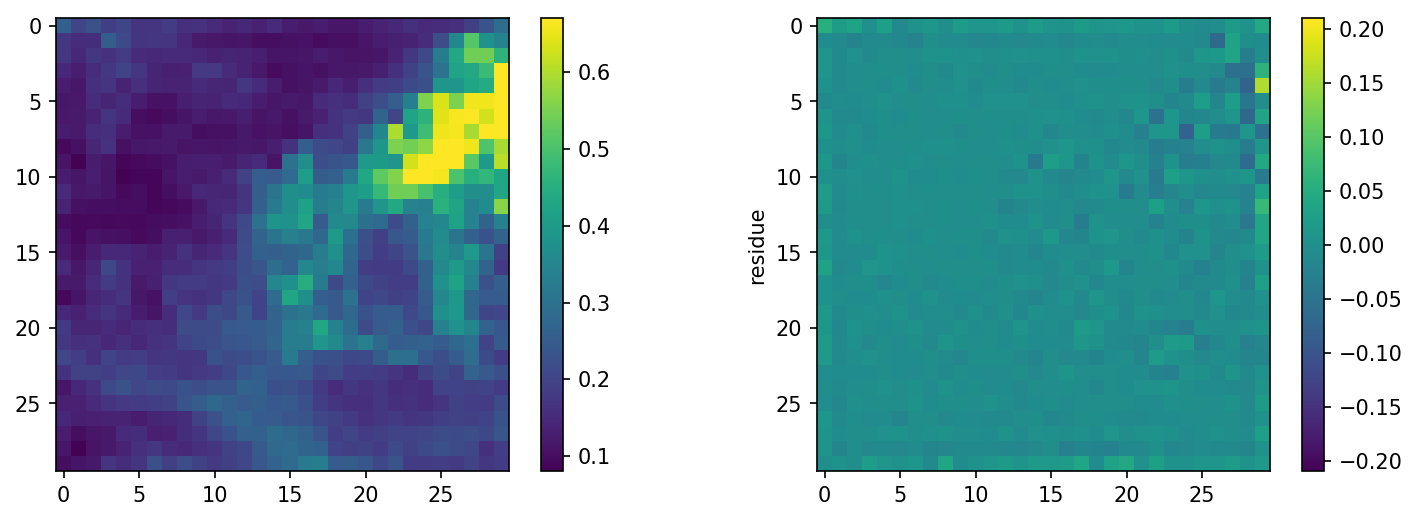

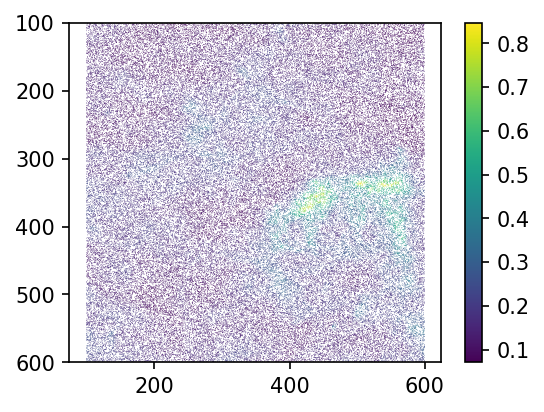

In [270]:
nptspp=10
np.random.seed(100)
indexset=np.random.choice(100**3,size=nptspp*10000,replace=False)
print('points per pix:',len(set(indexset))/10000)

width = 30
_, dust_map = reconstruct_and_compare(data[indexset], width, 325, 300, a=2, return_map=True);plt.show()
fig = plt.figure(figsize=(4,3), dpi=150)

example_1=data[indexset]
plt.scatter(example_1[:, 0], example_1[:,1], c=example_1[:, 2], s=.11,linewidths =0)
plt.ylim(600, 100)
plt.colorbar()
plt.savefig('observationsN=10.png')
plt.show()

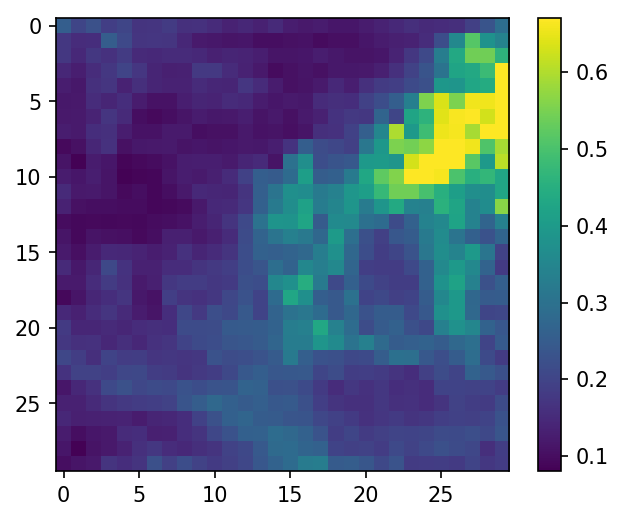

In [281]:
plt.figure(figsize=(5,4), dpi=150)
plt.imshow(dust_map, interpolation='none',vmin=0.08,vmax=.67)
plt.colorbar()
plt.savefig('dustmapN=10.png')

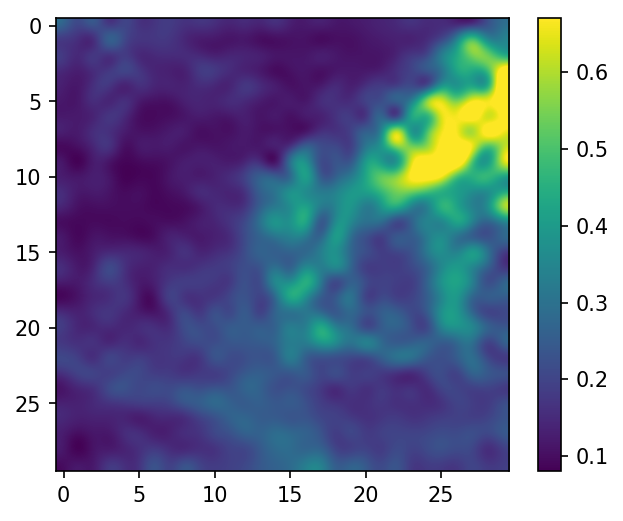

In [282]:
plt.figure(figsize=(5,4), dpi=150)
plt.imshow(dust_map, interpolation='lanczos',vmin=0.08,vmax=.67)
plt.colorbar()
plt.savefig('interpolated-mapN=10.png')

## Examples of reconstructed images using polyfit2d with deg=1,2. See Section 5.2 in the report.

Polynomial 2d method with degree 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


FOM: 0.006548377125371693


0.006548377125371693

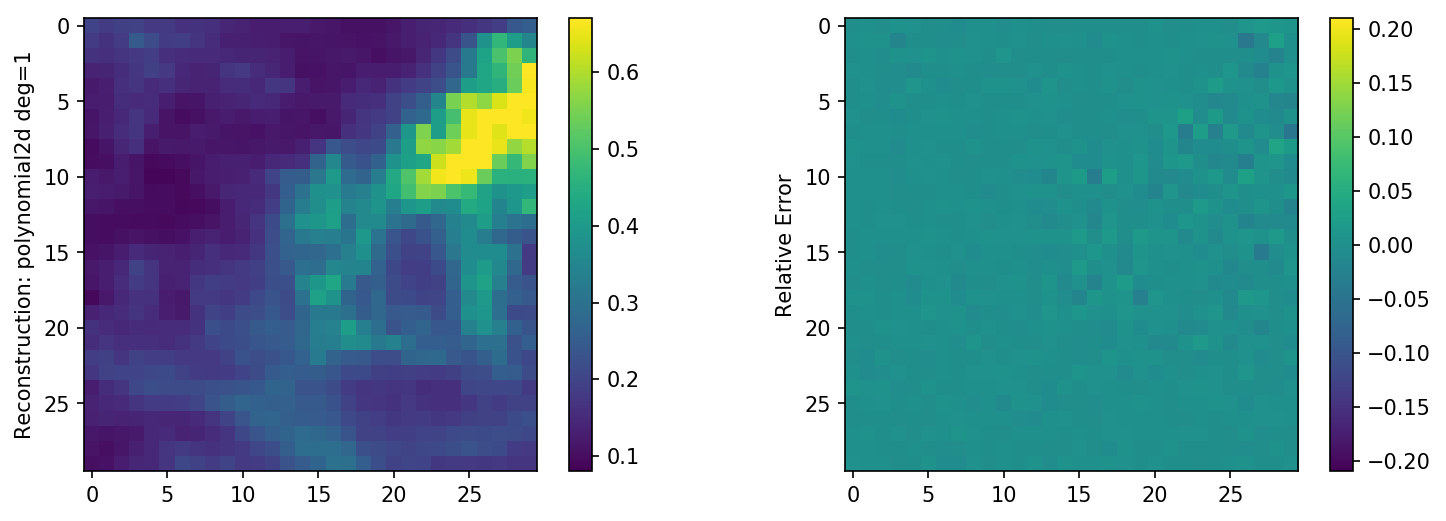

In [284]:
x_start = 325
y_start = 300
deg = [1, 1]  #, [3, 3], [4, 4]):
print ("Polynomial 2d method with degree {}".format(deg[0]))
method = 'polynomial2d{}'.format(deg[0])
reconstruct(buckets, method, x_start, y_start, ptspp=11, plot_results=True, degree=deg[0])

Polynomial 2d method with degree 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


FOM: 0.13957006973531638


0.13957006973531638

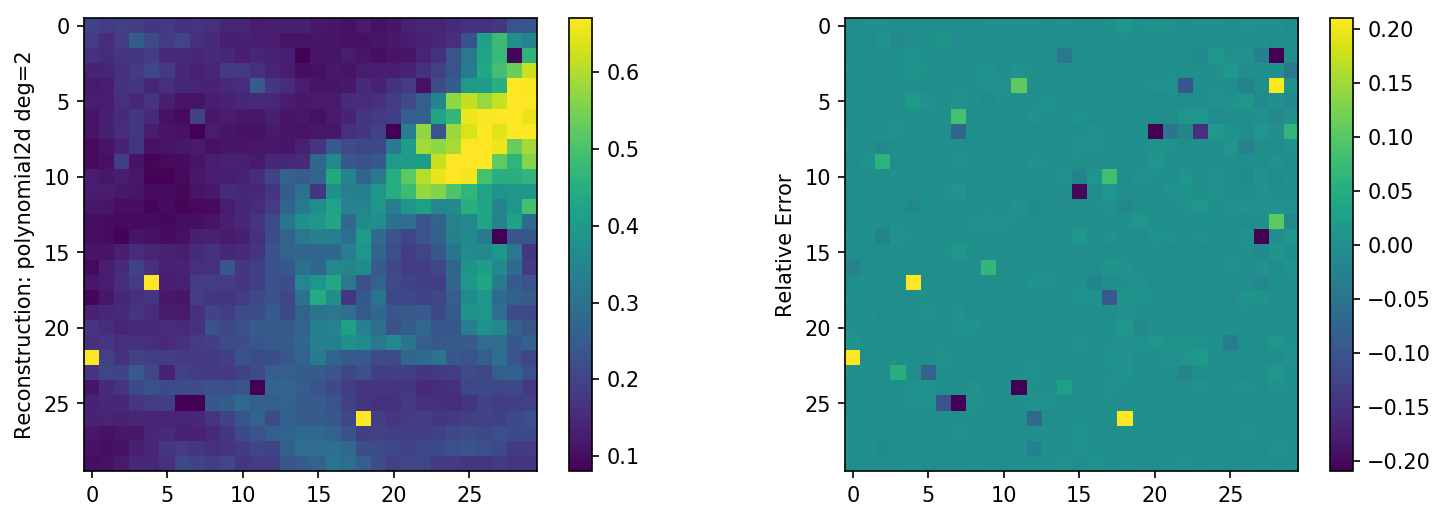

In [285]:
deg = [2, 2]  #, [3, 3], [4, 4]):
print ("Polynomial 2d method with degree {}".format(deg[0]))
method = 'polynomial2d{}'.format(deg[0])
reconstruct(buckets, method, x_start, y_start, ptspp=11, plot_results=True, degree=deg[0])

# Thank you for reading!